# Predictive models on categorical varibles 

Among the basic classification techniques that you are familiar with (i.e., decision tree, k-NN, logistic regression, NB, SVM) use all that would be applicable to this dataset to predict the evaluation of the cars based on their characteristics. Explore how well these techniques perform for several different parameter values. Present a brief overview of your predictive modeling process, explorations, and discuss your results. Present your final model (i.e., the best predictive model that you were able to come up with), and discuss its performance in a comprehensive manner (overall accuracy; per-class performance, i.e., whether this model predicts all classes equally well, or if there some classes for which it does much better than others; etc.)

# Set Up

## Data Exploration

In [24]:
#Importing the basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import plotly.offline as py
import seaborn as sns

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [4]:
cars = pd.read_csv('car.data', names =  ['buying', 'maint', 'doors','capacity','lug_boot','safety','class'])

In [5]:
#Taking an overview of data
cars.sample(10)

,buying,maint,doors,capacity,lug_boot,safety,class
975,med,high,2,2,med,low,unacc
277,vhigh,med,4,2,big,med,unacc
1219,med,low,3,2,med,med,unacc
1316,low,vhigh,2,more,small,high,unacc
249,vhigh,med,3,2,big,low,unacc
1712,low,low,5more,4,small,high,good
1676,low,low,4,2,small,high,unacc
1374,low,vhigh,4,more,big,low,unacc
1117,med,med,3,4,small,med,acc
541,high,high,2,2,small,med,unacc


In [6]:
cars.doors.replace(('5more'),('5'),inplace=True)
cars.capacity.replace(('more'),('5'),inplace=True)

In [7]:
cars.describe()

,buying,maint,doors,capacity,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,med,med,2,2,med,med,unacc
freq,432,432,432,576,576,576,1210


The count for every feature is the same as the number of rows, which indicates no missing values.  
Yay!  
Since we are dealing with categorical data, we are shown the distinct values in the unique column.

The distribution of the acceptability of the cars.

In [8]:
#Lets find out the number of cars in each evaluation category
cars['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

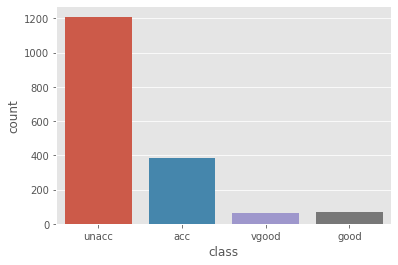

In [9]:
sns.countplot(cars['class'])

As we can see, our target varible is highly skewed 

## Initial Feature Exploration

So we need to predict the acceptability of the car given the 6 features. Let’s try to find the relationship between each feature variable with the target variable. I’ll use pandas crosstab to make a table showing the relationship and Plotly to plot an interactive graph for the same.

In [10]:
buy = pd.crosstab(cars['buying'], cars['class'])
maint = pd.crosstab(cars['maint'], cars['class'])
drs = pd.crosstab(cars['doors'], cars['class'])
prsn = pd.crosstab(cars['capacity'], cars['class'])
lb = pd.crosstab(cars['lug_boot'], cars['class'])
sfty = pd.crosstab(cars['safety'], cars['class'])

In [11]:
buy

class,acc,good,unacc,vgood
buying,,,,
high,108,0,324,0
low,89,46,258,39
med,115,23,268,26
vhigh,72,0,360,0


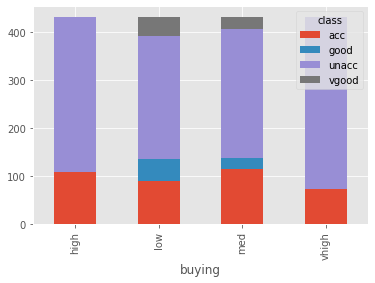

In [12]:
buy.plot.bar(stacked=True)

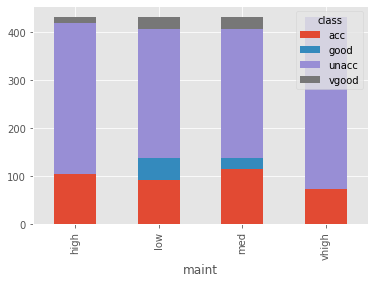

In [13]:
maint.plot.bar(stacked=True)

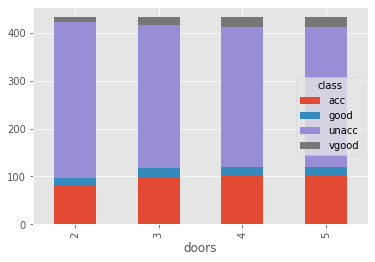

In [14]:
drs.plot(kind='bar',stacked=True)

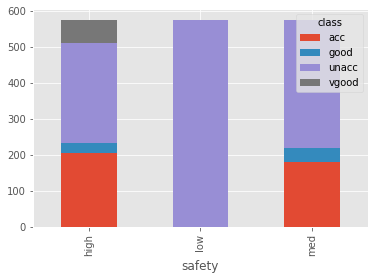

In [15]:
sfty.plot.bar(stacked=True)

## Encoding and Data Spliting

We need to encode the categorical data 
There are two options, either we use label encoder or one hot encoder.
Intuitively, predictors' value in the dataset such as 'low, med, high' introduce an underlying linear order itself, therefore, it's alright to transform data with ordinal encoder.

In [16]:
cars1 = cars.copy()
cars1['class'].replace(('unacc', 'acc', 'good', 'vgood'), (1, 2, 3,4), inplace = True)
cars1['buying'].replace(('vhigh', 'high', 'med', 'low'), (4,3, 2, 1), inplace = True)
cars1['maint'].replace(('vhigh', 'high', 'med', 'low'), (4,3, 2, 1), inplace = True)
cars1['lug_boot'].replace(('small','med','big'),(1,2,3),inplace=True)
cars1['safety'].replace(('low','med','high'),(1,2,3),inplace=True)

Feature Correlation:



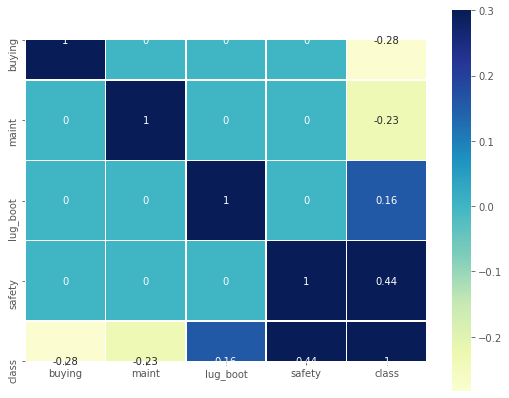

In [17]:
print("Feature Correlation:\n")

fig, ax = plt.subplots(figsize=(9,7))
ax.set_ylim(6.0, 0)

ax=sns.heatmap(cars1.corr(),center=0,vmax=.3,cmap="YlGnBu",
            square=True, linewidths=.5, annot=True)

Ignoring the diagonal values, it can be seen that most of the columns shows very weak correlation with 'class'.
'safety' column is having a correlation with 'class'.

In [18]:
#Dividing the dataframe into x features and y target variable
X1 = cars1.drop(['class'],axis = 1)
y1 = cars1['class']

In [19]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [20]:
X3 = cars.drop(['class'],axis = 1)
y3 = y1
# Using pandas dummies function to encode categorical data

X3 = pd.get_dummies(X3,columns= ['buying','capacity','doors','maint','lug_boot'], 
                    prefix_sep='_', drop_first=True)
X3['safety'].replace(('low','med','high'),(0,1,2),inplace=True)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.3, random_state = 41)

# Model Building

In [22]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

## Logistic Regression

### Tuning parameter - GridSearchCV

In [25]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

# Set the parameters by cross-validation
parameters = [{'C': np.logspace(-5, 6, 15)}]

logistic = LogisticRegression(solver='newton-cg', penalty='l2') # when 'car class' is not binary

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s\n" % score)

    lg_gscv = GridSearchCV(logistic, parameters, cv=5, scoring='%s_micro' % score)
    lg_gscv.fit(X1_train, y1_train)

    print("Best parameters set found on development set:\n")

    print(lg_gscv.best_params_)
    print("\nGrid scores on development set:\n")

    means = lg_gscv.cv_results_['mean_test_score']
    stds = lg_gscv.cv_results_['std_test_score']
 #   for mean, std, params in zip(means, stds, svc_gscv.cv_results_['params']):
        #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    
    print("\nDetailed classification report:")
    print("\nThe model is trained on the full development set.")
    print("\nThe scores are computed on the full evaluation set.\n")

    y_true, y_pred = y1_test, lg_gscv.predict(X1_test)
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 19.306977288832496}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           1       0.87      0.95      0.91       358
           2       0.62      0.58      0.60       118
           3       0.50      0.21      0.30        19
           4       0.83      0.42      0.56        24

    accuracy                           0.81       519
   macro avg       0.71      0.54      0.59       519
weighted avg       0.80      0.81      0.80       519

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 19.306977288832496}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are computed on the full evaluation se

In [28]:
from sklearn.model_selection import cross_val_score, validation_curve

print("Cross-Validation Score :{0:.3f}".format(np.mean(cross_val_score(lg_gscv.best_estimator_, X1, y1, cv=5))))

Cross-Validation Score :0.778


For C value, use a wider range of np.logspace(-5, 6, 15) to get a rough value, which ends up with 19 in this case. Then zoom in to a narrower range of C = np.linspace(20,40, num=15) to find a better value. Let's look at the validation curve to find a final C in the model.

### Tuning parameter - Validation curve

Text(0.5, 1.0, 'validation_curve with different C')

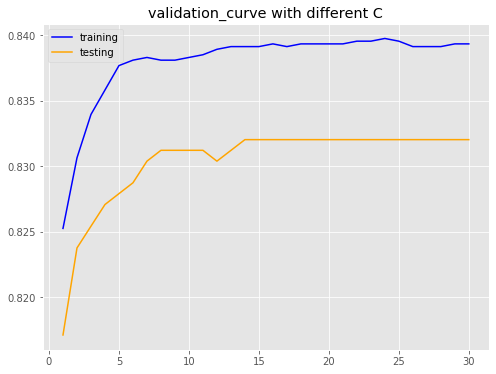

In [30]:
from sklearn.model_selection import cross_val_score, validation_curve

C=np.linspace(1,30, num=30)
curve = validation_curve(logistic,X1_train,y1_train, cv=5,param_name='C',param_range=C)

n=len(C)
train_score=[curve[0][i].mean() for i in range (0,n)]
test_score=[curve[1][i].mean() for i in range (0,n)]

fig=plt.figure(figsize=(8,6))
#plt.ylim(.85,.9)
plt.plot(C,train_score,color='blue', label='training')
plt.plot(C,test_score,color='orange', label='testing')
plt.legend()
plt.xticks=C
plt.title('validation_curve with different C')

### Fit the model

In [38]:
from sklearn.metrics import precision_recall_fscore_support, f1_score,confusion_matrix
# Multi-class
lgc=LogisticRegression(solver='newton-cg',C=15)
lgc.fit(X1_train,y1_train)
y1_pred = lgc.predict(X1_test)

# binary class
#lg_bin=LogisticRegression(solver='liblinear',C=15)
#lg_bin.fit(X1_train,y1_train)

f1_LR = f1_score(y1_test,y1_pred, average='micro')

print("Training Accuracy: ",lgc.score(X1_train, y1_train))
print("Testing Accuracy: ", lgc.score(X1_test, y1_test))
print("Cross-Validation Score :{0:.3f}".format(np.mean(cross_val_score(lgc, X1, y1, cv=5))))

cm = confusion_matrix(y1_test, y1_pred)
print(cm)
print(classification_report(y1_test,y1_pred)) 

Training Accuracy:  0.8354011579818031
Testing Accuracy:  0.8111753371868978
Cross-Validation Score :0.778
[[340  14   2   2]
 [ 48  68   2   0]
 [  1  15   3   0]
 [  0  14   0  10]]
              precision    recall  f1-score   support

           1       0.87      0.95      0.91       358
           2       0.61      0.58      0.59       118
           3       0.43      0.16      0.23        19
           4       0.83      0.42      0.56        24

    accuracy                           0.81       519
   macro avg       0.69      0.53      0.57       519
weighted avg       0.80      0.81      0.80       519



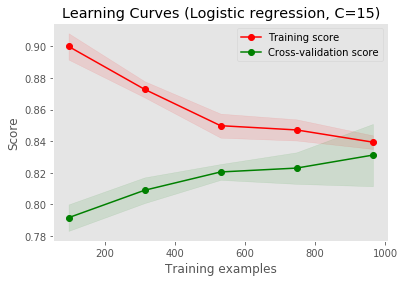

In [39]:
from sklearn.model_selection import learning_curve
 
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
        lgc, X1_train, y1_train, cv=5,n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.title("Learning Curves (Logistic regression, C=15)")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")


plt.show()

## K-NN

### Hypertuning using GridSearchCV

In [40]:
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier


#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1,15)}

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    knn_gscv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='%s_micro' % score)
    knn_gscv.fit(X1_train, y1_train)

    print("Best parameters set found on development set:\n")

    print(knn_gscv.best_params_)
    print("\nGrid scores on development set:\n")

    means = knn_gscv.cv_results_['mean_test_score']
    stds = knn_gscv.cv_results_['std_test_score']
 #   for mean, std, params in zip(means, stds, svc_gscv.cv_results_['params']):
        #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    
    print("\nDetailed classification report:")
    print("\nThe model is trained on the full development set.")
    print("\nThe scores are computed on the full evaluation set.\n")

    y_true, y_pred = y1_test, knn_gscv.predict(X1_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 5}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       358
           2       0.90      0.88      0.89       118
           3       0.78      0.74      0.76        19
           4       0.89      0.67      0.76        24

    accuracy                           0.94       519
   macro avg       0.88      0.82      0.85       519
weighted avg       0.94      0.94      0.94       519


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'n_neighbors': 5}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are computed on the full evaluation set.

         

Text(0.5, 1.0, 'K value vs Accuracy Plot')

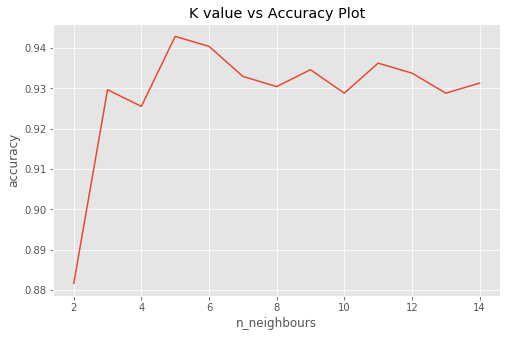

In [41]:
# Plot K vs accuracy
avg_score=[]
for k in range(2,15):
    knn=KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(knn,X1_train,y1_train,cv=5,scoring='accuracy')
    avg_score.append(score.mean())
    
plt.figure(figsize=(8,5))
plt.plot(range(2,15),avg_score)
plt.xlabel("n_neighbours")
plt.ylabel("accuracy")
plt.title("K value vs Accuracy Plot")

#plt.xticks(range(2,30,2))

Both grid search cross validation and plot show that neighbor = 5 is a potential good hyperparameter.

### Fit the model

In [189]:
#Using KNN classifier, 

knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn.fit(X1_train, y1_train)

y1_pred = knn.predict(X1_test)
f1_KNN = f1_score(y1_test,y1_pred, average='micro')

print("Training Accuracy: ",knn.score(X1_train, y1_train))
print("Testing Accuracy: ", knn.score(X1_test, y1_test))
print("Cross-Validation Score :{0:.3f}".format(np.mean(cross_val_score(knn, X1, y1, cv=5))))
cm = confusion_matrix(y1_test, y1_pred)
print('\n',cm,'\n')
print(classification_report(y1_test,y1_pred))

Training Accuracy:  0.9818031430934657
Testing Accuracy:  0.9421965317919075
Cross-Validation Score :0.813

 [[355   3   0   0]
 [ 12 104   1   1]
 [  0   4  14   1]
 [  0   5   3  16]] 

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       358
           2       0.90      0.88      0.89       118
           3       0.78      0.74      0.76        19
           4       0.89      0.67      0.76        24

    accuracy                           0.94       519
   macro avg       0.88      0.82      0.85       519
weighted avg       0.94      0.94      0.94       519



## SVM

### Grid Search

In [190]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

# Set the parameters by cross-validation
parameters = [{'kernel': ['rbf'], 
               'gamma': 10. ** np.arange(-5, 4),
               'C': [0.1, 1, 10, 100, 1000]},
              {'kernel': ['linear'], 
               'C': [0.1,  1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    svc_gscv = GridSearchCV(SVC(), parameters, cv=5, scoring='%s_micro' % score)
    
    svc_gscv.fit(X1_train, y1_train)

    print("Best parameters set found on development set:\n")

    print(svc_gscv.best_params_)
    print("\nGrid scores on development set:\n")

    means = svc_gscv.cv_results_['mean_test_score']
    stds = svc_gscv.cv_results_['std_test_score']
 #   for mean, std, params in zip(means, stds, svc_gscv.cv_results_['params']):
        #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    
    print("\nDetailed classification report:")
    print("\nThe model is trained on the full development set.")
    print("\nThe scores are computed on the full evaluation set.\n")

    y_true, y_pred = y1_test, svc_gscv.predict(X1_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       358
           2       0.96      0.95      0.95       118
           3       0.85      0.89      0.87        19
           4       0.92      0.92      0.92        24

    accuracy                           0.97       519
   macro avg       0.93      0.94      0.93       519
weighted avg       0.98      0.97      0.98       519


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:


Detailed classification report:

The model is trained on the full development set.

The scores are c

### Fit rbf SVC Model

From the GridSearch result, we find that with `kernel = 'rbf', C = 100, gamma = 0.1`, the model can achive best performance with respect to recall and accuracy. Since the unbalanced label of our target, I decide to go with recall, intuitively because we want to capture as many cars that will not be accepted as possible.

In [44]:
from sklearn.svm import SVC

svc_rbf = SVC(kernel = 'rbf', C = 100, gamma = 0.1)
svc_rbf.fit(X1_train,y1_train)
y1_pred = svc_rbf.predict(X1_test)
f1_SVC_rbf = f1_score(y1_test,y1_pred, average='micro')

print("Training Accuracy: ",svc_rbf.score(X1_train, y1_train))
print("Testing Accuracy: ", svc_rbf.score(X1_test, y1_test))
print("Cross-Validation Score :{0:.3f}".format(np.mean(cross_val_score(svc_rbf, X1, y1, cv=5))))

cm = confusion_matrix(y1_test, y1_pred)
print('\n',cm,'\n')
print(classification_report(y1_test,y1_pred))

Training Accuracy:  0.9983457402812241
Testing Accuracy:  0.9749518304431599
Cross-Validation Score :0.877

 [[355   3   0   0]
 [  3 112   2   1]
 [  0   1  17   1]
 [  0   1   1  22]] 

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       358
           2       0.96      0.95      0.95       118
           3       0.85      0.89      0.87        19
           4       0.92      0.92      0.92        24

    accuracy                           0.97       519
   macro avg       0.93      0.94      0.93       519
weighted avg       0.98      0.97      0.98       519



### Learning curve

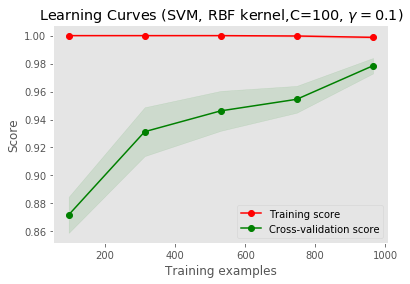

In [45]:
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
  
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
train_sizes, train_scores, test_scores = learning_curve(
        svc_rbf, X1_train, y1_train, cv=5, n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.title("Learning Curves (SVM, RBF kernel,C=100, $\gamma=0.1$)")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")


plt.show()

## NB

In [46]:
#Using NB classifier
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X1_train, y1_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [47]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y1_pred = gnb.fit(X1_train, y1_train).predict(X1_test)
f1_gnb = f1_score(y1_test,y1_pred, average='micro')

print("Number of mislabeled points out of a total {0} points :{1}".format(X1_test.shape[0],(y1_test != y1_pred).sum()))

print("Training Accuracy: ",gnb.score(X1_train, y1_train))
print("Testing Accuracy: ", gnb.score(X1_test, y1_test))
print("Cross-Validation Score :{0:.3f}".format(np.mean(cross_val_score(gnb, X1, y1, cv=5))))

cm = confusion_matrix(y1_test, y1_pred)
print('\n',cm,'\n')
print(classification_report(y1_test,y1_pred))

Number of mislabeled points out of a total 519 points :123
Training Accuracy:  0.7766749379652605
Testing Accuracy:  0.7630057803468208
Cross-Validation Score :0.754

 [[332  17   1   8]
 [ 36  36   5  41]
 [  1   5   4   9]
 [  0   0   0  24]] 

              precision    recall  f1-score   support

           1       0.90      0.93      0.91       358
           2       0.62      0.31      0.41       118
           3       0.40      0.21      0.28        19
           4       0.29      1.00      0.45        24

    accuracy                           0.76       519
   macro avg       0.55      0.61      0.51       519
weighted avg       0.79      0.76      0.75       519



## Decision Tree

### Find Hyperparameter

Text(0, 0.5, 'accuracy')

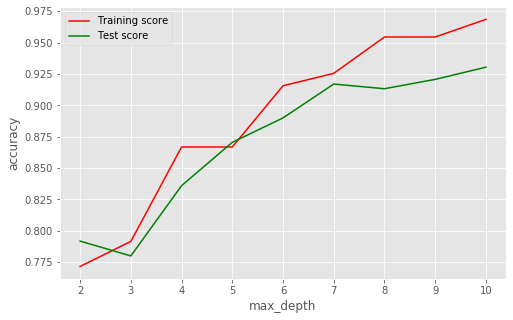

In [48]:
# Plot max_depth vs accuracy

from sklearn.tree import DecisionTreeClassifier

avg_train=[]
avg_test=[]

for max_depth in range(2,11):
    dtree = DecisionTreeClassifier(max_depth=max_depth)
    train_score=cross_val_score(dtree,X1_train,y1_train,cv=5,scoring='accuracy')
    test_score =cross_val_score(dtree,X1_test,y1_test,cv=5,scoring='accuracy')
    avg_train.append(train_score.mean())
    avg_test.append(test_score.mean())
    
plt.figure(figsize=(8,5))
plt.plot(range(2,11), avg_train,color="r",label="Training score")
plt.plot(range(2,11), avg_test, color="g", label="Test score")
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("accuracy")


Max depth of 9 looks to be a balanced cutoff point

### Fit the model

In [49]:
#Trying decision tree classifier
dtree = DecisionTreeClassifier(random_state = 0, max_depth=9)
dtree.fit(X1_train, y1_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [50]:
y1_pred = dtree.predict(X1_test)
F1_dtree = f1_score(y1_test,y1_pred, average='micro')
 
print("Training Accuracy: ",dtree.score(X1_train, y1_train))
print("Testing Accuracy: ", dtree.score(X1_test, y1_test))

cm = confusion_matrix(y1_test, y1_pred)
print('\n',cm,'\n')
print(classification_report(y1_test,y1_pred))

Training Accuracy:  0.9842845326716294
Testing Accuracy:  0.9556840077071291

 [[352   6   0   0]
 [  6 105   6   1]
 [  0   0  17   2]
 [  0   0   2  22]] 

              precision    recall  f1-score   support

           1       0.98      0.98      0.98       358
           2       0.95      0.89      0.92       118
           3       0.68      0.89      0.77        19
           4       0.88      0.92      0.90        24

    accuracy                           0.96       519
   macro avg       0.87      0.92      0.89       519
weighted avg       0.96      0.96      0.96       519



## Random Forest 

### Try a Basic Model

In [51]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=51)

rfc.fit(X1_train,y1_train)
y1_pred = rfc.predict(X1_test)

print("Training Accuracy: ",rfc.score(X1_train, y1_train))
print("Testing Accuracy: ", rfc.score(X1_test, y1_test))

Training Accuracy:  1.0
Testing Accuracy:  0.9402697495183044


So, the basic model of RFC is giving 94% accuracy, but training score is clearly overfit. Now, check the effect of n_estimators on the model

### Fine Tune Hyperparameter

Text(0.5, 1.0, 'number of trees vs Accuracy Plot')

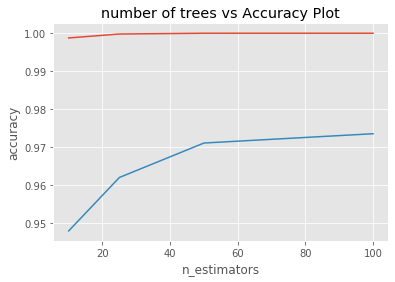

In [52]:
# Plot number of trees vs accuracy
n_tree=[10,25,50,100]
curve = validation_curve(rfc,X1_train,y1_train,cv=5,param_name='n_estimators',
                         param_range=n_tree)
train_score=[curve[0][i].mean() for i in range (0,len(n_tree))]
test_score=[curve[1][i].mean() for i in range (0,len(n_tree))]

f,ax=plt.subplots(1)
plt.plot(n_tree,train_score)
plt.plot(n_tree,test_score)
plt.xticks=n_tree

plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.title("number of trees vs Accuracy Plot")
#ax.set_ylim(0.8,1.1)


So, with the increasing n_estimators, test accuracy is increasing. Model is evaluating best at n_estimators=50. After n_estimators = 50, model starts overfitting.
Now, we've reached approx. 97.1% accuracy.

Now, check how the model fits for various values of 'max_features'

In [54]:
rfc = RandomForestClassifier(n_estimators=50,random_state=51)
rfc.fit(X1_train,y1_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

Text(0.5, 1.0, 'validation_curve of random forest with 50 trees')

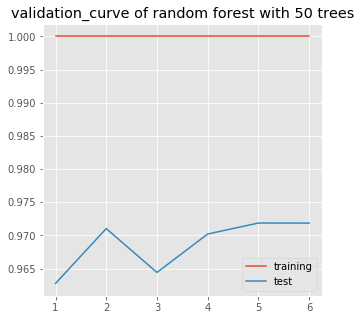

In [55]:
param_range=range(1,len(X1.columns)+1)
curve=validation_curve(RandomForestClassifier(n_estimators=50,random_state=51),X1_train,y1_train,cv=5,
    param_name='max_features',param_range=param_range)

train_score=[curve[0][i].mean() for i in range (0,len(param_range))]
test_score=[curve[1][i].mean() for i in range (0,len(param_range))]
f, ax = plt.subplots(1,figsize=(5,5))
plt.plot(param_range,train_score, label='training')
plt.plot(param_range,test_score,label='test')
plt.xticks=param_range
#ax.set_ylim(0.96,1.01)
plt.legend()
plt.title('validation_curve of random forest with 50 trees')

From above graph, it is clear that model is giving best resut for max_features=5. Still the model is overfitting.

Now we've reached 97.2% accuracy approx.

We can also check of other parameters like 'max_depth','criterion',etc using above code.Another simple way is to use GridSearch to get combination of best parameters. As this dataset is small, GridSearch will take less time to complete.

In [56]:
param_grid={'criterion':['gini','entropy'],
           'max_depth':[2,5,10,20],
           'max_features':[2,4,5,6,'auto'],
           'max_leaf_nodes':[2,3,None],}

grid=GridSearchCV(estimator=RandomForestClassifier(n_estimators=50,random_state=51),
                  param_grid=param_grid,cv=10)

grid.fit(X1_train,y1_train)

print(grid.best_params_)
print(grid.best_score_)
F1_rfc = f1_score(y1_test,grid.fit(X1_train,y1_train).predict(X1_test), average='micro')

/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'criterion': 'entropy', 'max_depth': 20, 'max_features': 6, 'max_leaf_nodes': None}
0.9859387923904053


/Users/xueni/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



So, with above parameters for random forest model, we've reached 98.6% accuracy.

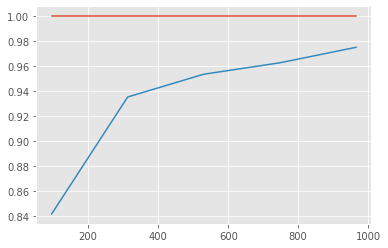

In [57]:
curve=learning_curve(RandomForestClassifier(n_estimators=50,
                                         criterion='entropy',
                                         max_features=6,
                                         max_depth=20,
                                         random_state=51,max_leaf_nodes=None),
                  X1_train,y1_train, cv=5)

size=curve[0]
train_score=[curve[1][i].mean() for i in range (0,5)]
test_score=[curve[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(6,4))
plt.plot(size,train_score)
plt.plot(size,test_score)

##### Model is overfitting as train accuracy is 1 ,but test accuracy is much less.
I've already tried changing RFC parameters to tackle overfitting. But, still it is not reduced.To reduce variance, we can
1. Increase number of samples. (It is clear from above graph that incresing number of samples will improve model)
2. Reduce number of features

#### Feature Reduction

In [223]:
feature_import = pd.DataFrame([rfc.feature_importances_], columns=X1.columns)

print(feature_import)

     buying     maint     doors  capacity  lug_boot    safety
0  0.154819  0.151853  0.059702  0.251283  0.094677  0.287667


From feature importances, it is clear that 'doors' feature is least important.
So, train our model excluding that feature.

In [58]:
X1_train_new, X1_test_new, y1_train_new, y1_test_new = train_test_split(
    X1[['buying', 'maint', 'capacity', 'lug_boot', 'safety']],
    y1, test_size=0.3, random_state=42)

In [59]:
rfc1=RandomForestClassifier(n_estimators=50,criterion='entropy',max_features=4,max_depth=10,random_state=51,
    max_leaf_nodes=None)
rfc1.fit(X1_train_new,y1_train_new)

rfc1.score(X1_test_new,y1_test_new)

0.930635838150289

Our data already has less features and even if we drop the least important feature, then also the accuracy is reducing to 93.06%

So, dropping a feature is not an option to reduce variance in our model.The only option we are left with is to get more data.

Conclusion:
Random Forest Classifier is the best suitable model for this data with following parameters:
n_estimators: 50
criterion: entropy
max_depth: 10
max_features: 4
max_leaf_nodes: None

We are able to achieve 98.6% accuracy with this model

# Model Evaluation

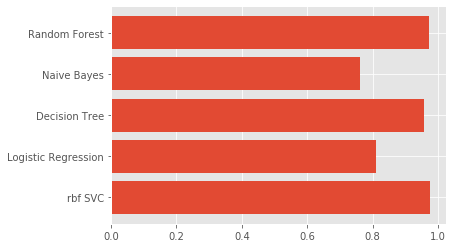

In [60]:
models=['rbf SVC','Logistic Regression','Decision Tree','Naive Bayes','Random Forest']
f1 = np.array([f1_SVC_rbf, f1_LR, F1_dtree,f1_gnb,F1_rfc])

y_pos = np.arange(len(models))
plt.barh(y_pos, f1)
plt.yticks(y_pos, ('rbf SVC','Logistic Regression','Decision Tree','Naive Bayes','Random Forest'))
plt.show()

In [61]:
score = pd.DataFrame([f1],columns=models)
score

,rbf SVC,Logistic Regression,Decision Tree,Naive Bayes,Random Forest
0,0.974952,0.811175,0.955684,0.763006,0.971098


__Conclusion__
rbf SVM Classifier and Random Forest Classifier are roughly equally suitable models for this classification context, however, be aware that Random Forest tends to show overfitting, and accuary won't get better with trees growing or features reduction. 

We are able to achieve 98.6% weighted accuracy with this model

-- END --